In [5]:
import geopandas as gp
import pandas as pd
import pathlib
import numpy as np
from shapely.geometry import LineString, MultiLineString, Point
from shapely import ops
import libpysal
from datetime import datetime
from tqdm import tqdm
import random

# load data frames
import load_data_module

In [6]:
# Load preprocessed data
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf = load_data_module.raw_full_trip_gdf, load_data_module.raw_trip_sp_gdf, load_data_module.raw_trip_ep_gdf
assert len(raw_full_trip_gdf) == len(raw_trip_sp_gdf) == len(raw_trip_ep_gdf)

raw_full_trip_gdf

PERSON_ID  TRIP_ID           TRIP_START             TRIP_END  \
0         16348   985222  2022-10-31 09:15:57  2022-10-31 09:34:08   
1         16348   985223  2022-10-31 11:04:22  2022-10-31 11:09:12   
2         16348   985301  2022-10-31 11:38:24  2022-10-31 11:43:51   
3         16348   985302  2022-10-31 12:01:50  2022-10-31 12:12:00   
4         16348   985459  2022-10-31 13:23:11  2022-10-31 13:53:17   
...         ...      ...                  ...                  ...   
1380      17269  1003131  2022-11-07 15:01:30  2022-11-07 15:09:31   
1381      17269  1003715  2022-11-07 16:58:18  2022-11-07 17:44:12   
1382      17269  1006304  2022-11-09 17:50:05  2022-11-09 18:17:57   
1383      17269  1009686  2022-11-12 14:03:45  2022-11-12 16:50:44   
1384      17272   988300  2022-11-01 16:14:50  2022-11-01 16:25:47   

      TRIP_LEN_IN_MTRS  TRIP_DURATION_IN_SECS  \
0                 2574                   1090   
1                  353                    290   
2                  315                    327   
3                  335                    608   
4                 3503                   1803   
...                ...                    ...   
1380               676                    481   
1381             10514                   2748   
1382             10279                   1670   
1383             35594                  10014   
1384               468                    638   

                                               geometry    TRIP_WD   TRIP_DATE  
0     LINESTRING (13.50497 52.45445, 13.50498 52.454...     Monday  2022-10-31  
1     LINESTRING (13.52685 52.45699, 13.52685 52.457...     Monday  2022-10-31  
2     LINESTRING (13.52438 52.45529, 13.52433 52.455...     Monday  2022-10-31  
3     LINESTRING (13.52601 52.45596, 13.52601 52.455...     Monday  2022-10-31  
4     LINESTRING (13.52692 52.45710, 13.52694 52.457...     Monday  2022-10-31  
...                                                 ...        ...         ...  
1380  LINESTRING (13.32606 52.51031, 13.32632 52.510...     Monday  2022-11-07  
1381  LINESTRING (13.24104 52.52562, 13.24102 52.525...     Monday  2022-11-07  
1382  LINESTRING (13.13320 52.56350, 13.13332 52.563...  Wednesday  2022-11-09  
1383  LINESTRING (13.13360 52.56364, 13.13321 52.563...   Saturday  2022-11-12  
1384  LINESTRING (13.32616 52.51200, 13.32616 52.511...    Tuesday  2022-11-01  

[1024 rows x 9 columns]

In [7]:
tesselation_gdf = gp.read_file("W:/Master-Thesis-Repository/data/freemove_dlr_data/tessellation.geojson")

In [8]:
print(f"Number of unique users in data: {raw_full_trip_gdf.PERSON_ID.unique().size}\nNumber of Trips: {raw_full_trip_gdf.TRIP_ID.unique().size}\nNumber of Start Points: {raw_trip_sp_gdf.TRIP_ID.unique().size}\nNumber of End Points: {raw_trip_ep_gdf.TRIP_ID.unique().size}")

Number of unique users in data: 62
Number of Trips: 1024
Number of Start Points: 1024
Number of End Points: 1024


# Merge Start Points (SP) and End Points (EP) with Tessellation

In [9]:
# SP
# Spatial join points to polygons
gdf_sp = gp.sjoin(
    tesselation_gdf[["tile_id", "geometry"]],
    raw_trip_sp_gdf,
    how="inner"
).drop('index_right', axis=1)

In [10]:
# Spatial join points to polygons
gdf_ep = gp.sjoin(
    tesselation_gdf[["tile_id", "geometry"]],
    raw_trip_ep_gdf,
    how="inner"
).drop('index_right', axis=1)

# Extract Full Trips that Start and End within Tessellation Area

In [12]:
gdf_sp_ids = gdf_sp.TRIP_ID
gdf_ep_ids = gdf_ep.TRIP_ID

full_trip_gdf = raw_full_trip_gdf.query("TRIP_ID in @gdf_sp_ids and TRIP_ID in @gdf_ep_ids")
trip_sp_gdf = raw_trip_sp_gdf.query("TRIP_ID in @gdf_ep_ids")
trip_ep_gdf = raw_trip_ep_gdf.query("TRIP_ID in @gdf_sp_ids")

gdf_sp = gdf_sp.query("TRIP_ID in @gdf_ep_ids")
gdf_ep = gdf_ep.query("TRIP_ID in @gdf_sp_ids")

assert len(full_trip_gdf) == len(trip_sp_gdf) == len(trip_ep_gdf) == len(gdf_sp) == len(gdf_ep) == len(set(trip_sp_gdf.TRIP_ID).intersection(set(trip_ep_gdf.TRIP_ID)))

# Evaluation Functions

In [13]:
from sklearn import metrics

def evaluate(clustering):
    # Get ground truth labels
    df = full_trip_gdf
    df['ID'] = df.sort_values('TRIP_ID').groupby('PERSON_ID').ngroup() # Sort TRIP ID ascending and set cluster id corresponding to PERSON_ID
    ground_truth = df.sort_values('TRIP_ID').ID.to_list()

    # All of these metrics are symmetric and some of them are accounting for chance depending on the number of classes and clusters present in the data
    score_funcs = [
        ("V-measure", metrics.v_measure_score),
        ("Rand index", metrics.rand_score),
        ("ARI", metrics.adjusted_rand_score),
        ("MI", metrics.mutual_info_score),
        ("NMI", metrics.normalized_mutual_info_score),
        ("AMI", metrics.adjusted_mutual_info_score),
    ]

    for marker, (score_name, score_func) in zip("d^vx.,", score_funcs):
        print(f"{score_name}: {score_func(ground_truth, clustering)}")

In [14]:
def getIndexInList(trip_id):
    index_list = full_trip_gdf.sort_values('TRIP_ID').TRIP_ID.to_list()

    return index_list.index(trip_id)


In [64]:
from tslearn.metrics import lcss

def LCSS(traj1_linestr, traj2_linestr, eps=0.11):
    s1 = traj1_linestr.coords.xy
    s2 = traj2_linestr.coords.xy
    return lcss(s1, s2, eps=eps)



assert LCSS(full_trip_gdf.geometry.iloc[0], full_trip_gdf.geometry.iloc[0]) == 1

# Concatenate Subsequent Locations

In [37]:
# Calculate mapping of continued trips that happened subsequent to and from same tile
mapping_cont_trips = []
for index, trip in gdf_ep.sort_values('TRIP_ID').iterrows():
    te_1_id = trip.TRIP_ID
    te_1_tid = trip.tile_id
    te_1_dt = pd.to_datetime(trip['TRIP_END'], format='%Y-%m-%d %H:%M:%S')
    ts_1_dt = pd.to_datetime(trip['TRIP_START'], format='%Y-%m-%d %H:%M:%S')

    inflow = gdf_ep.query("tile_id == @te_1_tid")
    inflow['TRIP_END'] = pd.to_datetime(inflow.TRIP_END, format='%Y-%m-%d %H:%M:%S')
    inflow['TRIP_START'] = pd.to_datetime(inflow.TRIP_START, format='%Y-%m-%d %H:%M:%S')
    inflow['INFLOW_HR_DIFF'] = inflow.TRIP_END.apply(lambda x: (x - te_1_dt).total_seconds()/3600)
    inflow = inflow.query("(INFLOW_HR_DIFF <= 4) and (INFLOW_HR_DIFF >= 4)") # Take trips 
    inflow = inflow.query("(TRIP_START > @te_1_dt) or (@ts_1_dt > TRIP_END)") # Ignore trips that have happened simultaneously

    # if more than one trip has arrived in +- hour window, then do not merge this trip
    if len(inflow) > 1:
        continue

    
    # Get all trips that started from same tile as t_1 has ended in
    ts_2 = gdf_sp.query("tile_id == @te_1_tid")

    # if trip has started in tesselation area but ended outside than there will be no endpoint (happened 1 time)
    if ts_2.empty:
        continue

    # get difference between two trips hours (seconds divided by 3600 gets hours)
    ts_2['TRIP_START'] = pd.to_datetime(ts_2.TRIP_START, format='%Y-%m-%d %H:%M:%S')
    ts_2['TRIP_END'] = pd.to_datetime(ts_2.TRIP_END, format='%Y-%m-%d %H:%M:%S')
 
    ts_2['hr_diff'] = ts_2['TRIP_START'].apply(lambda x: (x - te_1_dt).total_seconds()/3600)

    # Only consider trips that started within a certain time after the initial trip ended in the same tessellation tile
    ts_2 = ts_2[(ts_2['hr_diff'].astype(str).astype(float) <= 8) & (ts_2['hr_diff'].astype(str).astype(float) >= 0)]

    # Only consider trips that are not simultaneously
    ts_2 = ts_2.query("(TRIP_START > @te_1_dt) or (@ts_1_dt > TRIP_END)")

    # Only consider connection if exactly one trip started from same tile in time window
    if len(ts_2) == 1:
        mapping_cont_trips.append({
            'TRIP_ID': te_1_id,
            'TRIP_ID_CONT': ts_2.TRIP_ID.iloc[0]
        })
    

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [38]:
# Print num of matches and erronous ones out of these
mistakes = []
for conn in mapping_cont_trips:
    trip_ids = [conn['TRIP_ID'],  conn['TRIP_ID_CONT']]
    unique_person = raw_full_trip_gdf.query("TRIP_ID in @trip_ids").PERSON_ID.nunique()

    if unique_person > 1:
        mistakes.append(raw_full_trip_gdf.query("TRIP_ID in @trip_ids"))


print(f"Number of edges (matched) between trips: {len(mapping_cont_trips)}")
print(f"Number of wrong matches: {len(mistakes)}")

Number of edges (matched) between trips: 306
Number of wrong matches: 12


In [ ]:
# Plot wrong matches
pd.concat(mistakes, keys=list(range(1,len(mistakes)+1))).reset_index(level=1, drop=True).reset_index(names="CONN_ID").head(6).explore(column="TRIP_ID")

In [40]:
def getTripChain(trip_id, chain=[]):
    """
    Recursive function that returns a list for all chained trips for a give orig trip_id
    """
    if type(trip_id) == str:
        trip_id = int(trip_id)

    # add orig trip_id to output list
    if len(chain) == 0:
        chain.append(trip_id)

    # recursively find all chained trips originating from the orig trip_id
    for edge in mapping_cont_trips:
        if edge['TRIP_ID'] == trip_id:
            chain.append(edge['TRIP_ID_CONT'])
            getTripChain(edge['TRIP_ID_CONT'], chain)
            
        
    return chain


assert getTripChain('998178') == [998178]


In [41]:
### Merge trips according to matching

# Get trip chain for each trip
trip_chains = [getTripChain(trip, chain=[]) for trip in gdf_sp.TRIP_ID]

# Sort for longest chain first
trip_chains.sort(key = len, reverse = True)

# Create dictionary to store mappings for evaluation
trip_concat_dict = {}

covered_trips = []
merged_trips_gdf = []
for chain in trip_chains:
    # Check if any of the trips in the current chain has already been merged as part of another chain
    # Since we start with the longest chain and iterate through descending sorted list, we only retain the complete chains
    if set(chain).intersection(set(covered_trips)):
        continue

    # add trip chain to dict for evaluation later
    trip_concat_dict[chain[0]] = chain[1:]
    
    # add all trip ids part of current chain to list so that every trip is only contained in longest chain of it
    covered_trips += chain

    trips = raw_full_trip_gdf.query("TRIP_ID in @chain").sort_values("TRIP_START")
    trips["temp"] = 1

    trips = trips.groupby('temp').agg(list).reset_index(drop=True).rename(columns={'TRIP_ID': 'TRIP_ID_CHAIN'})

    trips["wkt_trip"] = trips['geometry'].apply(lambda x: ", ".join([str(i) for i in x]).replace("), LINESTRING (", ", "))
    trips['TRIP_START'] = trips['TRIP_START'].apply(lambda x: min(x))
    trips['TRIP_END'] = trips['TRIP_END'].apply(lambda x: max(x))
    trips['TRIP_LEN_IN_MTRS'] = trips['TRIP_LEN_IN_MTRS'].apply(lambda x: sum(x))
    trips['TRIP_DURATION_IN_SECS'] = trips['TRIP_DURATION_IN_SECS'].apply(lambda x: sum(x))
    trips['TRIP_WD'] = trips['TRIP_WD'].apply(lambda x: x[0]) # see below
    trips['TRIP_DATE'] = trips['TRIP_DATE'].apply(lambda x: x[0]) # see below
    trips['TRIP_ID'] = trips['TRIP_ID_CHAIN'].apply(lambda x: x[0]) # assign trip_id of first trip in chain to concatenated trip
    # This is the TRIP_ID of the last trip in the chain to be concatenated
    trips['TRIP_ID_LAST'] = trips['TRIP_ID_CHAIN'].apply(lambda x: x[-1]) 

    # Note: Here we are assigning the PERSON_ID of the first trip to the concatenated trip. This of course can be erroneous if the concatenation itself is wrong
    trips['PERSON_ID'] = trips['PERSON_ID'].apply(lambda x: x[0])
    trips = trips.drop(['geometry', 'TRIP_ID_CHAIN'], axis=1)

    trips = gp.GeoDataFrame(trips, geometry=gp.GeoSeries.from_wkt(trips['wkt_trip'])).drop('wkt_trip', axis=1)

    merged_trips_gdf.append(trips)

trip_merged_gdf = pd.concat(merged_trips_gdf)

print(f"Number of trips that were matched at least once: {len(set(covered_trips))}")

Number of trips that were matched at least once: 983


In [42]:
# Concatenate all trips that were unmerged with the merged trips into a new gdf
unmerged_trips = full_trip_gdf.query("TRIP_ID not in @covered_trips")
full_trips_concat_gdf = pd.concat([unmerged_trips, trip_merged_gdf])
full_trips_concat_gdf['TRIP_ID_FIRST'] = full_trips_concat_gdf['TRIP_ID'] # This is the same as TRIP_ID

# Assign TRIP_ID as TRIP_ID_LAST in case TRIP has not been merged and first and last TRIP_Id are in fact the same
full_trips_concat_gdf['TRIP_ID_LAST'] = np.where(full_trips_concat_gdf.TRIP_ID_LAST.isnull(), full_trips_concat_gdf.TRIP_ID, full_trips_concat_gdf.TRIP_ID_LAST)


In [43]:
# Filter for those trips that are still at the beginning of a trip even after concatenation of trip chain
t_id_sp = full_trips_concat_gdf.TRIP_ID_FIRST
t_id_ep = full_trips_concat_gdf.TRIP_ID_LAST

gdf_sp = gdf_sp.query("TRIP_ID in @t_id_ep")
# Also filter df containing the unmatched trajectories (LINESTRINGs)
trip_sp_gdf = trip_sp_gdf.query("TRIP_ID in @t_id_ep")

gdf_ep = gdf_ep.query("TRIP_ID in @t_id_sp")
trip_ep_gdf = trip_ep_gdf.query("TRIP_ID in @t_id_sp")

assert len(trip_sp_gdf) == len(trip_ep_gdf) == len(gdf_sp) == len(gdf_ep)

In [44]:
# This creates the array with clustering IDs after the concatenation step
clustering_concat = {}
for index, trip in full_trips_concat_gdf.reset_index().sort_values('TRIP_ID').iterrows():
    trip_order_index = getIndexInList(trip.TRIP_ID)

    clustering_concat[trip_order_index] = index

    if trip.TRIP_ID in trip_concat_dict:
        for t in trip_concat_dict[trip.TRIP_ID]:
            clustering_concat[getIndexInList(t)] = index

clustering_concat = list(dict(sorted(clustering_concat.items())).values())

print(f"Number of unique clusters: {len(set(clustering_concat))}")

Number of unique clusters: 703


# From Start Points (SPs)

In [45]:
# Generate home locations (HL) from SPs
gdf_sp.index=pd.to_datetime(gdf_sp.TRIP_START)
gdf_sp['hl'] = gdf_sp['TRIP_START'].apply(lambda x: 1 if x in gdf_sp.between_time('6:00', '10:00').TRIP_START else 0).astype(object)
gdf_sp.reset_index(inplace=True, drop=True)
gdf_sp

tile_id                                           geometry  PERSON_ID  \
0    141123  POLYGON ((12.95560 52.43616, 12.95560 52.43725...      16657   
1    160374  POLYGON ((13.00949 52.39342, 13.00949 52.39452...      16657   
2    170037  POLYGON ((13.03644 52.41315, 13.03644 52.41425...      16657   
3    173896  POLYGON ((13.04722 52.41425, 13.04722 52.41534...      16657   
4    174536  POLYGON ((13.04902 52.41096, 13.04902 52.41205...      16363   
..      ...                                                ...        ...   
698  426691  POLYGON ((13.75330 52.51932, 13.75330 52.52042...      16972   
699  426696  POLYGON ((13.75330 52.52479, 13.75330 52.52588...      16972   
700  429269  POLYGON ((13.76049 52.52588, 13.76049 52.52697...      16972   
701  429269  POLYGON ((13.76049 52.52588, 13.76049 52.52697...      16972   
702  449209  POLYGON ((13.81618 52.53353, 13.81618 52.53463...      16972   

     TRIP_ID           TRIP_START             TRIP_END  TRIP_LEN_IN_MTRS  \
0     992891  2022-11-03 11:47:30  2022-11-03 14:39:09             13072   
1    1005274  2022-11-08 18:31:46  2022-11-08 18:48:55              6678   
2     999320  2022-11-05 15:56:10  2022-11-05 16:10:08              1278   
3     999087  2022-11-05 15:19:38  2022-11-05 15:29:28               857   
4     987720  2022-11-01 10:36:49  2022-11-01 10:43:21                43   
..       ...                  ...                  ...               ...   
698  1006892  2022-11-10 09:21:57  2022-11-10 10:33:03             34081   
699   985709  2022-10-31 17:48:48  2022-10-31 17:59:43              3194   
700   999784  2022-11-05 17:49:52  2022-11-05 18:35:25             25821   
701  1005191  2022-11-08 13:07:32  2022-11-08 14:08:45             32769   
702  1006387  2022-11-09 18:03:52  2022-11-09 18:16:17              5731   

     TRIP_DURATION_IN_SECS    TRIP_WD   TRIP_DATE       LONG        LAT hl  
0                    10296   Thursday  2022-11-03  12.955835  52.436510  0  
1                     1028    Tuesday  2022-11-08  13.010955  52.393532  0  
2                      838   Saturday  2022-11-05  13.037317  52.413978  0  
3                      590   Saturday  2022-11-05  13.047252  52.414783  0  
4                      392    Tuesday  2022-11-01  13.049884  52.411936  0  
..                     ...        ...         ...        ...        ... ..  
698                   4261   Thursday  2022-11-10  13.753523  52.519871  1  
699                    655     Monday  2022-10-31  13.754448  52.525464  0  
700                   2732   Saturday  2022-11-05  13.760897  52.526300  0  
701                   3672    Tuesday  2022-11-08  13.761264  52.526422  0  
702                    745  Wednesday  2022-11-09  13.817761  52.534313  0  

[703 rows x 13 columns]

In [46]:
# Extract only those cells that are HL
gdf_hl_sp = gdf_sp[gdf_sp['hl'] == 1]

In [47]:
# create spatial weights matrix
W = libpysal.weights.Queen.from_dataframe(gdf_hl_sp)

# get component labels
components = W.component_labels

gdf_hl_combined_sp = pd.merge(gp.sjoin(
    gdf_hl_sp,
    gdf_hl_sp.dissolve(by=components)[["geometry"]],
    how="left"
), gdf_hl_sp.dissolve(by=components)[["geometry"]].reset_index(), left_on="index_right", right_on='index', suffixes=("__drop", "")).drop(['index', 'index_right', 'geometry__drop'], axis=1)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 53 disconnected components.
 There are 34 islands with ids: 0, 1, 2, 3, 6, 7, 10, 11, 12, 13, 14, 28, 30, 31, 32, 33, 34, 42, 45, 50, 51, 52, 53, 54, 67, 69, 73, 76, 86, 87, 91, 92, 93, 96.
  warnings.warn(message)


In [48]:
# Compute count of unique HL per Peson (HL here is already the merged tiles)
gdf_hl_combined_sp = pd.merge(gdf_hl_combined_sp, gdf_hl_combined_sp.astype({'geometry': 'string'}).groupby('PERSON_ID')[['geometry']].nunique().reset_index().rename(columns={'geometry': 'CNT_UNIQUE_HL'}), how="left")

# TODO: Add number of trips per merged tile
#gdf_hl_combined_sp = pd.merge(gdf_hl_combined_sp, gdf_hl_combined_sp.groupby(['PERSON_ID', 'geometry']).nunique().reset_index()[['PERSON_ID', 'TRIP_ID']].rename(columns={'TRIP_ID': 'CNT_TRIPS_PER_HL'}), suffixes=("", "_drop"))

# using dictionary to convert specific columns
convert_dict = {'PERSON_ID': object,
                'CNT_UNIQUE_HL': int
                }
 
gdf_hl_combined_sp = gdf_hl_combined_sp.astype(convert_dict)

# From End Points (EPs)

In [ ]:
raw_trip_ep_gdf.groupby('PERSON_ID').count().TRIP_ID.plot.hist(bins=100)

In [ ]:
raw_trip_ep_gdf.groupby(['PERSON_ID', 'TRIP_DATE']).count().reset_index('TRIP_DATE').TRIP_ID.plot.hist(bins=30)

In [49]:
# Generate home locations (HL) from EPs
gdf_ep.index=pd.to_datetime(gdf_ep.TRIP_END)
gdf_ep['hl'] = gdf_ep['TRIP_END'].apply(lambda x: 1 if x in gdf_ep.between_time('16:00', '00:00').TRIP_END else 0).astype(object)
gdf_ep.reset_index(inplace=True, drop=True)
gdf_ep

tile_id                                           geometry  PERSON_ID  \
0    160374  POLYGON ((13.00949 52.39342, 13.00949 52.39452...      16657   
1    166822  POLYGON ((13.02746 52.41315, 13.02746 52.41425...      16657   
2    167780  POLYGON ((13.02926 52.75700, 13.02926 52.75809...      16363   
3    170038  POLYGON ((13.03644 52.41425, 13.03644 52.41534...      16657   
4    174536  POLYGON ((13.04902 52.41096, 13.04902 52.41205...      16363   
..      ...                                                ...        ...   
698  426691  POLYGON ((13.75330 52.51932, 13.75330 52.52042...      16972   
699  426691  POLYGON ((13.75330 52.51932, 13.75330 52.52042...      16972   
700  426691  POLYGON ((13.75330 52.51932, 13.75330 52.52042...      16972   
701  426716  POLYGON ((13.75330 52.54665, 13.75330 52.54774...      16972   
702  427337  POLYGON ((13.75510 52.52260, 13.75510 52.52370...      16363   

     TRIP_ID           TRIP_START             TRIP_END  TRIP_LEN_IN_MTRS  \
0    1005273  2022-11-08 17:51:38  2022-11-08 18:02:55              3854   
1     992891  2022-11-03 11:47:30  2022-11-03 14:39:09             13072   
2    1010710  2022-11-13 11:48:57  2022-11-13 12:51:38             46105   
3     999087  2022-11-05 15:19:38  2022-11-05 15:29:28               857   
4     987540  2022-11-01 10:03:42  2022-11-01 10:06:14               343   
..       ...                  ...                  ...               ...   
698  1000173  2022-11-06 00:38:31  2022-11-06 01:11:47             21897   
699   988376  2022-11-01 17:41:22  2022-11-01 18:52:36             33787   
700   993475  2022-11-03 18:01:42  2022-11-03 19:12:36             33426   
701   985709  2022-10-31 17:48:48  2022-10-31 17:59:43              3194   
702   985353  2022-10-31 10:37:56  2022-10-31 11:25:39             23717   

     TRIP_DURATION_IN_SECS   TRIP_WD   TRIP_DATE       LONG        LAT hl  
0                      677   Tuesday  2022-11-08  13.010944  52.393673  1  
1                    10296  Thursday  2022-11-03  13.028853  52.413952  0  
2                     3750    Sunday  2022-11-13  13.030126  52.757131  0  
3                      590  Saturday  2022-11-05  13.037416  52.414257  0  
4                      152   Tuesday  2022-11-01  13.050717  52.411690  0  
..                     ...       ...         ...        ...        ... ..  
698                   1992    Sunday  2022-11-06  13.753683  52.519917  0  
699                   4270   Tuesday  2022-11-01  13.753823  52.519918  1  
700                   4248  Thursday  2022-11-03  13.753791  52.519995  1  
701                    655    Monday  2022-10-31  13.754873  52.547594  1  
702                   2863    Monday  2022-10-31  13.755188  52.522951  0  

[703 rows x 13 columns]

In [50]:
# Extract only those cells that are HL
gdf_hl_ep = gdf_ep[gdf_ep['hl'] == 1]

In [51]:
### Merge hl cells that are adjacent (touching) to each other 

# create spatial weights matrix
W = libpysal.weights.Queen.from_dataframe(gdf_hl_ep)

# get component labels
components = W.component_labels

gdf_hl_combined_ep = pd.merge(gp.sjoin(
    gdf_hl_ep,
    gdf_hl_ep.dissolve(by=components)[["geometry"]],
    how="left"
), gdf_hl_ep.dissolve(by=components)[["geometry"]].reset_index(), left_on="index_right", right_on='index', suffixes=("__drop", "")).drop(['index', 'index_right', 'geometry__drop'], axis=1)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 146 disconnected components.
 There are 75 islands with ids: 0, 3, 4, 5, 24, 25, 26, 30, 41, 42, 46, 58, 61, 62, 70, 77, 80, 88, 91, 92, 95, 96, 97, 98, 99, 104, 105, 118, 125, 126, 129, 141, 145, 146, 152, 159, 164, 170, 174, 175, 176, 177, 182, 185, 188, 191, 193, 196, 197, 198, 199, 202, 203, 207, 208, 209, 228, 245, 246, 247, 252, 255, 256, 261, 262, 266, 274, 287, 293, 300, 308, 311, 314, 315, 321.
  warnings.warn(message)


In [52]:
gdf_hl_combined_ep = pd.merge(gdf_hl_combined_ep, gdf_hl_combined_ep.astype({'geometry': 'string'}).groupby('PERSON_ID')[['geometry']].nunique().reset_index().rename(columns={'geometry': 'CNT_UNIQUE_HL'}), how="left")

# using dictionary to convert specific columns
convert_dict = {'PERSON_ID': object,
                'CNT_UNIQUE_HL': int
                }
 
gdf_hl_combined_ep = gdf_hl_combined_ep.astype(convert_dict)

# Merge (inner join)

In [ ]:
# Spatial join points to 
gdf_hl_combined = gp.sjoin(
    gdf_hl_combined_ep[["geometry"]],
    gdf_hl_combined_sp,
    how="inner"
).drop_duplicates(subset=['PERSON_ID', 'TRIP_ID']).drop('index_right', axis=1)

In [ ]:
# get number of unique HL per user
gdf_hl_combined = pd.merge(gdf_hl_combined, gdf_hl_combined.astype({'geometry': 'string'}).groupby('PERSON_ID')[['geometry']].nunique().reset_index().rename(columns={'geometry': 'CNT_UNIQUE_HL'}), suffixes=("_drop", ""), how="left", left_on='PERSON_ID', right_on='PERSON_ID').drop('CNT_UNIQUE_HL_drop', axis=1)


In [ ]:
gdf_hl_combined = pd.merge(gdf_hl_combined.astype({'geometry':'string'}), gdf_hl_combined.astype({'geometry':'string'}).groupby('geometry').count().reset_index().rename(columns={'tile_id': 'CNT_TRIPS_PER_GEOM'})[['geometry', 'CNT_TRIPS_PER_GEOM']], left_on="geometry", right_on="geometry")
geometry = gp.GeoSeries.from_wkt(gdf_hl_combined['geometry'])
gdf_hl_combined = gp.GeoDataFrame(gdf_hl_combined, geometry=geometry)


In [ ]:
# Get the trips that are from PERSON_IDs that overlap in their hl
intersected_person_id = pd.merge(gdf_hl_combined.astype({'geometry':'string'}), gdf_hl_combined.astype({'geometry':'string'}).groupby(['geometry'])[['PERSON_ID']].nunique().reset_index(), left_on="geometry", right_on="geometry", how="left")
intersected_person_id = intersected_person_id[intersected_person_id.PERSON_ID_y > 1]
intersected_person_id

geometry tile_id PERSON_ID_x  \
3    MULTIPOLYGON (((13.19814022115662 52.531346546...  228016       16659   
4    MULTIPOLYGON (((13.19814022115662 52.531346546...  227372       16356   
5    MULTIPOLYGON (((13.19814022115662 52.531346546...  227372       16356   
6    MULTIPOLYGON (((13.19814022115662 52.531346546...  227372       16356   
24   MULTIPOLYGON (((13.325700991501593 52.51166923...  274293       16656   
25   MULTIPOLYGON (((13.325700991501593 52.51166923...  273651       16972   
46   MULTIPOLYGON (((13.34726055832046 52.547737578...  280755       16970   
47   MULTIPOLYGON (((13.34726055832046 52.547737578...  280755       16643   
48   MULTIPOLYGON (((13.34726055832046 52.547737578...  280755       16643   
49   MULTIPOLYGON (((13.34726055832046 52.547737578...  280755       16643   
50   MULTIPOLYGON (((13.34726055832046 52.547737578...  280755       16643   
51   MULTIPOLYGON (((13.34726055832046 52.547737578...  280755       16643   
52   MULTIPOLYGON (((13.34726055832046 52.547737578...  280756       16643   
53   MULTIPOLYGON (((13.34726055832046 52.547737578...  280113       16643   
65   POLYGON ((13.36882012513933 52.523695304532815...  289094       16363   
66   POLYGON ((13.36882012513933 52.523695304532815...  289094       16655   
103  POLYGON ((13.411939258777068 52.54992258656927...  305191       16658   
104  POLYGON ((13.411939258777068 52.54992258656927...  304549       17266   

     TRIP_ID           TRIP_START             TRIP_END  TRIP_LEN_IN_MTRS  \
3    1004199  2022-11-08 07:25:09  2022-11-08 08:02:23              9099   
4    1013650  2022-11-16 09:31:22  2022-11-16 10:07:36              9546   
5     992654  2022-11-03 08:41:46  2022-11-03 08:53:46              1061   
6     985179  2022-10-31 09:29:04  2022-10-31 10:02:12              9624   
24   1002751  2022-11-07 09:51:43  2022-11-07 09:55:28               819   
25   1006129  2022-11-09 09:43:13  2022-11-09 10:15:13              7980   
46    992614  2022-11-03 08:59:51  2022-11-03 09:33:54              7811   
47   1009255  2022-11-12 09:37:11  2022-11-12 09:56:50              5788   
48    986203  2022-11-01 08:12:21  2022-11-01 08:55:42             18097   
49   1006736  2022-11-10 09:22:15  2022-11-10 10:05:08             14635   
50   1002821  2022-11-07 09:38:34  2022-11-07 10:14:36             14185   
51    989408  2022-11-02 09:41:30  2022-11-02 10:02:34              5954   
52   1008464  2022-11-11 09:58:12  2022-11-11 10:46:59             14619   
53    994016  2022-11-04 09:38:08  2022-11-04 10:01:29              6226   
65    987381  2022-11-01 09:09:32  2022-11-01 09:34:36             23323   
66   1008100  2022-11-11 06:42:34  2022-11-11 09:16:55            342511   
103  1011249  2022-11-14 08:34:56  2022-11-14 08:57:42              8265   
104   994920  2022-11-04 09:53:40  2022-11-04 09:56:38               666   

     TRIP_DURATION_IN_SECS    TRIP_WD   TRIP_DATE       LONG        LAT hl  \
3                     2233    Tuesday  2022-11-08  13.199311  52.532641  1   
4                     2172  Wednesday  2022-11-16  13.196940  52.531809  1   
5                      720   Thursday  2022-11-03  13.196940  52.531809  1   
6                     1986     Monday  2022-10-31  13.197644  52.531802  1   
24                     223     Monday  2022-11-07  13.327644  52.512145  1   
25                    1918  Wednesday  2022-11-09  13.325718  52.513387  1   
46                    2028   Thursday  2022-11-03  13.347083  52.546729  1   
47                    1179   Saturday  2022-11-12  13.345915  52.547440  1   
48                    2535    Tuesday  2022-11-01  13.345830  52.547472  1   
49                    2568   Thursday  2022-11-10  13.345649  52.547704  1   
50                    2160     Monday  2022-11-07  13.345801  52.547492  1   
51                    1264  Wednesday  2022-11-02  13.345867  52.547496  1   
52                    2910     Friday  2022-11-11  13.345655  52.547906  1   
53                    1401

<AxesSubplot: ylabel='Frequency'>

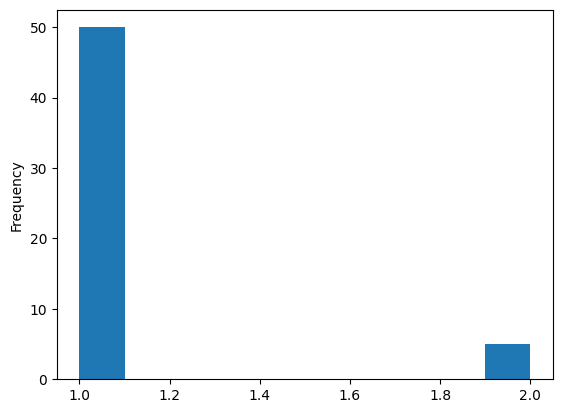

In [ ]:
gdf_hl_combined.astype({'geometry':'string'}).groupby(['geometry'])[['PERSON_ID']].nunique().PERSON_ID.plot.hist()

In [ ]:
gdf_hl_combined.PERSON_ID.unique().size

42

In [ ]:
gdf_hl_combined.explore(column="PERSON_ID")

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\explore.py:362: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat = pd.Categorical(gdf[column][~nan_idx], categories=categories)


# Merge (concatenate)

In [53]:
gp_combined_concat = pd.concat([gdf_hl_combined_ep, gdf_hl_combined_sp])

In [54]:
### Merge hl cells that are adjacent (touching) to each other 

# create spatial weights matrix
W = libpysal.weights.Queen.from_dataframe(gp_combined_concat)

# get component labels
components = W.component_labels

# We need to first join and then merge to first get the right index and then actually join the geometry 
gp_combined_concat = pd.merge(gp.sjoin(
    gp_combined_concat,
    gp_combined_concat.dissolve(by=components)[["geometry"]],
    how="left"
), gp_combined_concat.dissolve(by=components)[["geometry"]].reset_index(), left_on="index_right", right_on='index', suffixes=("__drop", "")).drop(['index', 'index_right', 'geometry__drop'], axis=1)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 165 disconnected components.
 There are 88 islands with ids: 0, 3, 4, 5, 24, 25, 26, 30, 41, 42, 49, 58, 62, 77, 80, 88, 91, 92, 95, 97, 99, 104, 105, 118, 126, 132, 141, 146, 147, 152, 159, 164, 170, 174, 175, 177, 182, 185, 188, 192, 193, 196, 197, 198, 199, 202, 203, 207, 208, 209, 228, 245, 246, 247, 252, 255, 256, 261, 262, 274, 287, 293, 300, 308, 311, 314, 315, 321, 323, 324, 325, 329, 333, 334, 335, 336, 352, 353, 355, 356, 367, 374, 389, 398, 408, 409, 413, 414.
  warnings.warn(message)


In [55]:
gp_combined_concat = pd.merge(gp_combined_concat.drop('CNT_UNIQUE_HL', axis=1), gp_combined_concat.astype({'geometry': 'string'}).groupby('PERSON_ID')[['geometry']].nunique().reset_index().rename(columns={'geometry': 'CNT_UNIQUE_HL'}), how="left")

# using dictionary to convert specific columns
convert_dict = {'PERSON_ID': object,
                'CNT_UNIQUE_HL': int
                }
 
gp_combined_concat = gp_combined_concat.astype(convert_dict)

In [ ]:
gp_combined_concat.explore(column="PERSON_ID")

<AxesSubplot: ylabel='Frequency'>

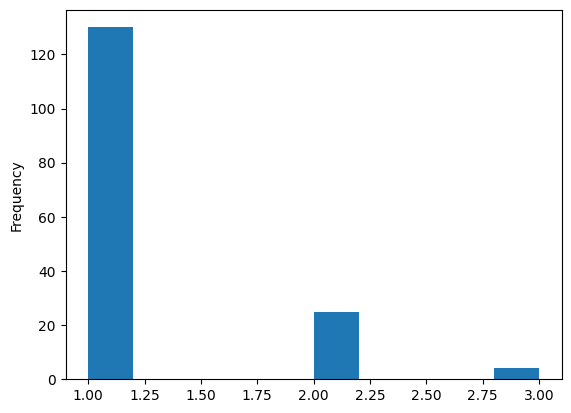

In [305]:
# Plot the number of unique users per HL tile (count of 1 means that the HL has only trips from one unique user, thus perfect clustering)
gp_combined_concat.astype({'geometry':'string'}).groupby(['geometry'])[['PERSON_ID']].nunique().PERSON_ID.plot.hist()

In [306]:
# Number of unique users for which at least one HL was identified
gp_combined_concat.PERSON_ID.unique().size

58

In [ ]:
se_trips = pd.concat([trip_sp_gdf.rename(columns={'TRIP_SP': 'geometry'}), trip_ep_gdf.rename(columns={'TRIP_EP': 'geometry'})]).astype({'TRIP_ID':'object', 'PERSON_ID':'object'}).sort_values('TRIP_ID')


se_trips[se_trips['PERSON_ID'].isin(random.sample(se_trips.PERSON_ID.to_list(), 10))].explore(column="PERSON_ID", marker_kwds=dict(radius=10, fill=True))

In [56]:
# Assign ID to HL
gp_combined_concat['HL_ID'] = gp_combined_concat.astype({'geometry': 'string'}).groupby('geometry').ngroup()

HL_table = gp_combined_concat[['geometry', 'HL_ID']].drop_duplicates()

print(f"Number of unique HL tiles: {len(HL_table)}")

Number of unique HL tiles: 165


# Check Matching Rate for Merged Tiles

In [57]:
# Merge all start and enpoints of all trajectories with HL tiles
# All successfully matched trips will have 0 in the "matched_sp/ep" column else NaN
matched_sp = gp.sjoin(
    trip_sp_gdf,
    gp_combined_concat.dissolve()[['geometry']], # Here we do the matching on the dissolved HL tiles since we only want to have one match per point to detect binary whether it is matched at all or not
    how="left"
).rename(columns={"index_right": "matched_sp"})

matched_ep = gp.sjoin(
    trip_ep_gdf,
    gp_combined_concat.dissolve()[['geometry']], # same here, see above
    how="left"
).rename(columns={"index_right": "matched_ep"})


In [58]:
# Get unmatched start and endpoints
unmatched_sp_t_ids = matched_sp[matched_sp.matched_sp.isnull()].TRIP_ID.to_list()
unmatched_ep_t_ids = matched_ep[matched_ep.matched_ep.isnull()].TRIP_ID.to_list()

# Number of unmatched trajectories that do not start or end in an HL tile
print(f"Number of unmatched trajectories that do neither start nor end in a HL tile: {len(full_trips_concat_gdf.query('TRIP_ID in @unmatched_sp_t_ids and TRIP_ID in @unmatched_ep_t_ids'))}")

# Get TRIP_IDs of matched start and endpoints
matched_sp_t_ids = matched_sp[~matched_sp.matched_sp.isnull()].TRIP_ID.to_list()
matched_ep_t_ids = matched_ep[~matched_ep.matched_ep.isnull()].TRIP_ID.to_list()

print(f"Number of trajectories that start AND end in a HL tile: {len(full_trips_concat_gdf.query('TRIP_ID in @matched_sp_t_ids and TRIP_ID in @matched_ep_t_ids'))}")

Number of unmatched trajectories that do neither start nor end in a HL tile: 85
Number of trajectories that start AND end in a HL tile: 169


In [368]:
full_trips_concat_gdf

PERSON_ID  TRIP_ID           TRIP_START             TRIP_END  \
12       16348   998821  2022-11-05 11:52:00  2022-11-05 12:55:30   
19       16348  1007359  2022-11-10 14:23:36  2022-11-10 15:17:14   
242      16363  1009899  2022-11-12 20:01:20  2022-11-12 20:16:14   
330      16649   989264  2022-11-02 08:26:00  2022-11-02 09:06:54   
410      16655  1007088  2022-11-10 10:41:52  2022-11-10 11:01:03   
..         ...      ...                  ...                  ...   
0        17266  1009434  2022-11-12 11:07:26  2022-11-12 13:43:45   
0        16972  1006892  2022-11-10 09:21:57  2022-11-10 10:33:03   
0        16972   985709  2022-10-31 17:48:48  2022-10-31 17:59:43   
0        16972   999784  2022-11-05 17:49:52  2022-11-05 18:35:25   
0        16972  1005191  2022-11-08 13:07:32  2022-11-08 14:08:45   

     TRIP_LEN_IN_MTRS  TRIP_DURATION_IN_SECS  \
12                912                   3808   
19               3193                   3212   
242              2246                    882   
330              6645                   2450   
410              5877                   1151   
..                ...                    ...   
0               42618                   9370   
0               34081                   4261   
0                3194                    655   
0               25821                   2732   
0               32769                   3672   

                                              geometry    TRIP_WD   TRIP_DATE  \
12   LINESTRING (13.50204 52.56255, 13.50191 52.562...   Saturday  2022-11-05   
19   LINESTRING (13.46312 52.51817, 13.46312 52.518...   Thursday  2022-11-10   
242  LINESTRING (13.52019 52.45374, 13.52019 52.453...   Saturday  2022-11-12   
330  LINESTRING (13.43336 52.50488, 13.43351 52.504...  Wednesday  2022-11-02   
410  LINESTRING (13.39120 52.52907, 13.39103 52.529...   Thursday  2022-11-10   
..                                                 ...        ...         ...   
0    LINESTRING (13.59800 52.27785, 13.59810 52.277...   Saturday  2022-11-12   
0    LINESTRING (13.75352 52.51987, 13.75352 52.519...   Thursday  2022-11-10   
0    LINESTRING (13.75445 52.52546, 13.75444 52.525...     Monday  2022-10-31   
0    LINESTRING (13.76090 52.52630, 13.76084 52.526...   Saturday  2022-11-05   
0    LINESTRING (13.76126 52.52642, 13.76117 52.526...    Tuesday  2022-11-08   

     TRIP_ID_LAST  TRIP_ID_FIRST  
12       998821.0         998821  
19      1007359.0        1007359  
242     1009899.0        1009899  
330      989264.0         989264  
410     1007088.0        1007088  
..            ...            ...  
0       1009434.0        1009434  
0       1006892.0        1006892  
0        985709.0         985709  
0        999784.0         999784  
0       1005191.0        1005191  

[703 rows x 11 columns]

In [59]:
s = gp.sjoin(
    trip_sp_gdf,
    HL_table, # Here we do the matching on the dissolved HL tiles since we only want to have one match per point to detect binary whether it is matched at all or not
    how="right").drop('index_left', axis=1).dropna()

In [370]:
s

PERSON_ID    TRIP_ID           TRIP_START             TRIP_END  \
0      16657.0  1005274.0  2022-11-08 18:31:46  2022-11-08 18:48:55   
1      16657.0   994272.0  2022-11-03 22:30:48  2022-11-03 22:53:00   
1      16657.0  1004375.0  2022-11-08 08:21:51  2022-11-08 08:53:08   
1      16657.0  1009656.0  2022-11-12 16:00:41  2022-11-12 16:17:15   
4      16657.0  1003325.0  2022-11-07 15:20:46  2022-11-07 15:43:38   
..         ...        ...                  ...                  ...   
414    16653.0   992415.0  2022-11-03 07:11:19  2022-11-03 07:53:43   
414    16653.0  1002768.0  2022-11-07 09:22:29  2022-11-07 10:07:44   
414    16653.0  1005271.0  2022-11-08 16:00:52  2022-11-08 16:19:07   
417    16348.0   985222.0  2022-10-31 09:15:57  2022-10-31 09:34:08   
418    17263.0  1002942.0  2022-11-07 09:51:40  2022-11-07 10:31:36   

     TRIP_LEN_IN_MTRS  TRIP_DURATION_IN_SECS   TRIP_WD   TRIP_DATE       LONG  \
0              6678.0                 1028.0   Tuesday  2022-11-08  13.010955   
1               696.0                 1330.0  Thursday  2022-11-03  13.051535   
1              5283.0                 1875.0   Tuesday  2022-11-08  13.050076   
1              1464.0                  994.0  Saturday  2022-11-12  13.051420   
4              1961.0                 1372.0    Monday  2022-11-07  13.055551   
..                ...                    ...       ...         ...        ...   
414           13139.0                 2544.0  Thursday  2022-11-03  13.502681   
414           13447.0                 2715.0    Monday  2022-11-07  13.502681   
414            2473.0                  859.0   Tuesday  2022-11-08  13.502407   
417            2574.0                 1090.0    Monday  2022-10-31  13.504967   
418           15175.0                 2380.0    Monday  2022-11-07  13.519659   

           LAT                                           geometry  HL_ID  
0    52.393532  POLYGON ((13.00949 52.39342, 13.00949 52.39452...     11  
1    52.415962  MULTIPOLYGON (((13.05261 52.41644, 13.05261 52...      0  
1    52.416721  MULTIPOLYGON (((13.05261 52.41644, 13.05261 52...      0  
1    52.416192  MULTIPOLYGON (((13.05261 52.41644, 13.05261 52...      0  
4    52.425762  POLYGON ((13.05441 52.42520, 13.05441 52.42630...     13  
..         ...                                                ...    ...  
414  52.537288  POLYGON ((13.50357 52.53790, 13.50357 52.53681...    151  
414  52.537288  POLYGON ((13.50357 52.53790, 13.50357 52.53681...    151  
414  52.537275  POLYGON ((13.50357 52.53790, 13.50357 52.53681...    151  
417  52.454451  POLYGON ((13.50357 52.45368, 13.50357 52.45477...    150  
418  52.513729  POLYGON ((13.51794 52.51276, 13.51794 52.51386...    155  

[375 rows x 12 columns]

In [60]:
e = gp.sjoin(
    trip_ep_gdf,
    HL_table, 
    how="right").drop('index_left', axis=1).dropna()

In [ ]:
m = gp.sjoin(
    trip_ep_gdf,
    HL_table, 
    how="left").explore()

HL_table.explore(m=m)

In [61]:
se_HL_table = pd.concat([s,e]).reset_index(drop=True)

print(f"Number of trips that match different HL tiles with their SP and EP: {se_HL_table.drop_duplicates(['TRIP_ID', 'HL_ID']).duplicated(['TRIP_ID']).sum()}")

Number of trips that match different HL tiles with their SP and EP: 82


In [394]:
se_HL_table.drop_duplicates(['TRIP_ID', 'HL_ID']).duplicated(subset='TRIP_ID', keep=False).reset_index(drop=True)

0      False
1      False
2      False
3       True
4       True
       ...  
753    False
754    False
755    False
756     True
757     True
Length: 758, dtype: bool

In [405]:
se_HL_table.drop_duplicates(['TRIP_ID', 'HL_ID'])[se_HL_table.drop_duplicates(['TRIP_ID', 'HL_ID']).duplicated(subset='TRIP_ID', keep=False)].sort_values('TRIP_ID')

PERSON_ID    TRIP_ID           TRIP_START             TRIP_END  \
131    16970.0   985481.0  2022-10-31 14:44:16  2022-10-31 14:52:02   
514    16970.0   985481.0  2022-10-31 14:44:16  2022-10-31 14:52:02   
59     16962.0   985638.0  2022-10-31 16:43:44  2022-10-31 16:45:59   
480    16962.0   985638.0  2022-10-31 16:43:44  2022-10-31 16:45:59   
645    16348.0   985659.0  2022-10-31 17:19:45  2022-10-31 18:05:21   
..         ...        ...                  ...                  ...   
767    17249.0  1011936.0  2022-11-14 17:30:15  2022-11-14 18:08:23   
351    16651.0  1013433.0  2022-11-15 19:50:01  2022-11-15 20:21:28   
421    16651.0  1013433.0  2022-11-15 19:50:01  2022-11-15 20:21:28   
76     16356.0  1014121.0  2022-11-16 15:51:55  2022-11-16 16:21:34   
501    16356.0  1014121.0  2022-11-16 15:51:55  2022-11-16 16:21:34   

     TRIP_LEN_IN_MTRS  TRIP_DURATION_IN_SECS    TRIP_WD   TRIP_DATE  \
131             685.0                  466.0     Monday  2022-10-31   
514             685.0                  466.0     Monday  2022-10-31   
59              458.0                  133.0     Monday  2022-10-31   
480             458.0                  133.0     Monday  2022-10-31   
645           13082.0                 2735.0     Monday  2022-10-31   
..                ...                    ...        ...         ...   
767            7572.0                 2282.0     Monday  2022-11-14   
351            6539.0                 1881.0    Tuesday  2022-11-15   
421            6539.0                 1881.0    Tuesday  2022-11-15   
76             1710.0                 1777.0  Wednesday  2022-11-16   
501            1710.0                 1777.0  Wednesday  2022-11-16   

          LONG        LAT                                           geometry  \
131  13.353276  52.549121  POLYGON ((13.35445 52.54992, 13.35624 52.54992...   
514  13.346947  52.546819  POLYGON ((13.34906 52.54665, 13.34726 52.54665...   
59   13.325058  52.516325  POLYGON ((13.32390 52.51714, 13.32570 52.51714...   
480  13.326464  52.519265  MULTIPOLYGON (((13.32570 52.52042, 13.32750 52...   
645  13.411572  52.521765  POLYGON ((13.41194 52.52260, 13.41194 52.52151...   
..         ...        ...                                                ...   
767  13.484829  52.464785  POLYGON ((13.48380 52.46463, 13.48380 52.46572...   
351  13.300257  52.530515  POLYGON ((13.29875 52.53025, 13.29875 52.53135...   
421  13.288892  52.498647  POLYGON ((13.28797 52.49855, 13.28797 52.49964...   
76   13.328590  52.511841  POLYGON ((13.32750 52.51167, 13.32570 52.51167...   
501  13.338667  52.503682  POLYGON ((13.34007 52.50401, 13.34007 52.50292...   

     HL_ID  
131     65  
514     62  
59      40  
480      5  
645    105  
..     ...  
767    143  
351     27  
421     26  
76      41  
501     50  

[164 rows x 12 columns]

In [68]:
len(set(gdf_ep.TRIP_ID).intersection(set(gdf_sp.TRIP_ID_LAST)))

AttributeError: 'GeoDataFrame' object has no attribute 'TRIP_ID_LAST'

In [ ]:
raw_full_trip_gdf[raw_full_trip_gdf.TRIP_ID == 1007230].explore()

In [413]:
full_trip_gdf[full_trip_gdf['PERSON_ID'] == 16361]

PERSON_ID  TRIP_ID           TRIP_START             TRIP_END  \
164      16361   985112  2022-10-31 08:03:55  2022-10-31 08:32:30   
165      16361   985398  2022-10-31 13:59:05  2022-10-31 14:05:43   
166      16361   985768  2022-10-31 17:55:08  2022-10-31 18:27:00   
167      16361   985769  2022-10-31 19:08:20  2022-10-31 19:50:58   
168      16361   985957  2022-11-01 07:27:39  2022-11-01 07:41:58   
169      16361   988315  2022-11-01 17:52:44  2022-11-01 18:19:18   
170      16361   991168  2022-11-02 16:15:27  2022-11-02 17:02:38   
171      16361   991169  2022-11-02 17:27:04  2022-11-02 17:35:35   
172      16361   993164  2022-11-03 16:21:08  2022-11-03 16:52:03   
173      16361   994525  2022-11-04 11:23:35  2022-11-04 12:12:28   
174      16361   997982  2022-11-05 09:41:55  2022-11-05 10:31:04   
175      16361   998747  2022-11-05 13:53:26  2022-11-05 14:34:45   
176      16361   999159  2022-11-05 15:45:37  2022-11-05 16:09:15   
177      16361  1000070  2022-11-05 23:47:50  2022-11-06 00:08:22   
178      16361  1000071  2022-11-06 00:18:53  2022-11-06 00:25:35   
179      16361  1002474  2022-11-07 08:03:00  2022-11-07 08:31:59   
180      16361  1003013  2022-11-07 13:54:36  2022-11-07 14:00:20   
181      16361  1003888  2022-11-07 19:07:03  2022-11-07 19:42:09   
182      16361  1005226  2022-11-08 16:53:56  2022-11-08 17:33:55   
183      16361  1006306  2022-11-09 17:45:44  2022-11-09 18:24:58   
184      16361  1006307  2022-11-09 18:35:38  2022-11-09 18:39:44   
185      16361  1007464  2022-11-10 18:54:49  2022-11-10 19:23:27   
186      16361  1007465  2022-11-10 19:33:54  2022-11-10 19:39:20   
187      16361  1007547  2022-11-10 21:19:09  2022-11-10 21:23:52   
188      16361  1008039  2022-11-11 08:55:32  2022-11-11 09:28:39   
189      16361  1008248  2022-11-11 12:33:54  2022-11-11 13:05:02   
190      16361  1008343  2022-11-11 14:57:38  2022-11-11 15:11:06   
191      16361  1008373  2022-11-11 15:36:25  2022-11-11 15:51:44   
192      16361  1009278  2022-11-12 10:09:34  2022-11-12 10:58:59   
193      16361  1009513  2022-11-12 14:03:52  2022-11-12 14:33:27   
194      16361  1009733  2022-11-12 16:16:54  2022-11-12 18:06:51   
195      16361  1010418  2022-11-13 10:10:54  2022-11-13 11:35:29   
196      16361  1010585  2022-11-13 12:28:12  2022-11-13 12:44:49   
197      16361  1010586  2022-11-13 13:04:19  2022-11-13 13:22:47   

     TRIP_LEN_IN_MTRS  TRIP_DURATION_IN_SECS  \
164             10415                   1713   
165               312                    398   
166              5680                   1910   
167             14168                   2556   
168              4593                    858   
169              9040                   1594   
170              4411                   2830   
171               802                    511   
172             10202                   1855   
173              3350                   2929   
174              8423                   2495   
175              4155                   2479   
176              9367                   1414   
177              2735                   1231   
178              6600                    401   
179             10316                   1736   
180              1158                    343   
181             10002                   2103   
182              3920                   2397   
183              3698                   2350   
184               359                    246   
185              6390                   1716   
186               433                    326   
187               467                    283   
188              8117                   1984   
189              1074                   1863   
190              1145                    808   
191              1241                    919   
192              9868                   2965   
193              3275                   1774   
194             11140                   6587   
195              5130                   5071   
196  

In [62]:
# Plot unmatched trajectories and OD points
m = gp_combined_concat.explore(column="PERSON_ID")

#full_trip_gdf.query('TRIP_ID in @unmatched_sp and TRIP_ID in @unmatched_ep').astype({'TRIP_ID': 'object'}).explore(m=m)

trip_sp_gdf.explore(m=m, color="green")

#full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1013433].explore(m=m, color="purple")
full_trip_gdf[full_trip_gdf['PERSON_ID'] == 16651].explore(m=m, color="purple")
full_trip_gdf[full_trip_gdf['PERSON_ID'] == 16361].explore(m=m, color="yellow")

trip_ep_gdf.explore(m=m, color="blue")

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\explore.py:362: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat = pd.Categorical(gdf[column][~nan_idx], categories=categories)


In [55]:
matched_sp.matched_sp.min()

0.0

In [53]:
pd.merge(matched_sp, matched_ep[['TRIP_ID', 'matched_ep']], left_on="TRIP_ID", right_on="TRIP_ID", how="left")

tile_id                                           geometry  PERSON_ID  \
0    141123  POLYGON ((12.95560 52.43616, 12.95560 52.43725...      16657   
2    164894  POLYGON ((13.02207 52.41425, 13.02207 52.41534...      16657   
3    167779  POLYGON ((13.02926 52.75592, 13.02926 52.75700...      16363   
4    170037  POLYGON ((13.03644 52.41315, 13.03644 52.41425...      16657   
5    173896  POLYGON ((13.04722 52.41425, 13.04722 52.41534...      16657   
..      ...                                                ...        ...   
988  426691  POLYGON ((13.75330 52.51932, 13.75330 52.52042...      16972   
991  426691  POLYGON ((13.75330 52.51932, 13.75330 52.52042...      16972   
992  426696  POLYGON ((13.75330 52.52479, 13.75330 52.52588...      16972   
993  429269  POLYGON ((13.76049 52.52588, 13.76049 52.52697...      16972   
994  429269  POLYGON ((13.76049 52.52588, 13.76049 52.52697...      16972   

     TRIP_ID           TRIP_START             TRIP_END  TRIP_LEN_IN_MTRS  \
0     992891  2022-11-03 11:47:30  2022-11-03 14:39:09             13072   
2    1005273  2022-11-08 17:51:38  2022-11-08 18:02:55              3854   
3    1011057  2022-11-13 19:00:13  2022-11-13 19:44:09             45556   
4     999320  2022-11-05 15:56:10  2022-11-05 16:10:08              1278   
5     999087  2022-11-05 15:19:38  2022-11-05 15:29:28               857   
..       ...                  ...                  ...               ...   
988   997265  2022-11-04 20:17:49  2022-11-04 20:20:07               127   
991  1005667  2022-11-09 06:58:11  2022-11-09 07:00:11               273   
992   985709  2022-10-31 17:48:48  2022-10-31 17:59:43              3194   
993   999784  2022-11-05 17:49:52  2022-11-05 18:35:25             25821   
994  1005191  2022-11-08 13:07:32  2022-11-08 14:08:45             32769   

     TRIP_DURATION_IN_SECS    TRIP_WD   TRIP_DATE       LONG        LAT hl  \
0                    10296   Thursday  2022-11-03  12.955835  52.436510  0   
2                      677    Tuesday  2022-11-08  13.023055  52.415306  0   
3                     2635     Sunday  2022-11-13  13.030424  52.756936  0   
4                      838   Saturday  2022-11-05  13.037317  52.413978  0   
5                      590   Saturday  2022-11-05  13.047252  52.414783  0   
..                     ...        ...         ...        ...        ... ..   
988                    138     Friday  2022-11-04  13.753761  52.519884  0   
991                    120  Wednesday  2022-11-09  13.753683  52.519917  1   
992                    655     Monday  2022-10-31  13.754448  52.525464  0   
993                   2732   Saturday  2022-11-05  13.760897  52.526300  0   
994                   3672    Tuesday  2022-11-08  13.761264  52.526422  0   

     matched_sp  
0           NaN  
2           NaN  
3           NaN  
4           NaN  
5           NaN  
..          ...  
988         0.0  
991         0.0  
992         NaN  
993         NaN  
994         NaN  

[703 rows x 14 columns]

In [62]:
len(set(matched_sp.TRIP_ID).intersection(set(matched_ep.TRIP_ID))) == len(set(matched_ep.TRIP_ID))

False

In [63]:
len(set(matched_ep.TRIP_ID))

703

In [64]:
len(set(matched_ep.TRIP_ID))

703

In [ ]:
# This creates the array with clustering IDs after the HL step
clustering_concat = {}
for index, trip in full_trips_concat_gdf.reset_index().sort_values('TRIP_ID').iterrows():
    trip_order_index = getIndexInList(trip.TRIP_ID)

    clustering_concat[trip_order_index] = index

    if trip.TRIP_ID in trip_concat_dict:
        for t in trip_concat_dict[trip.TRIP_ID]:
            clustering_concat[getIndexInList(t)] = index

clustering_concat = list(dict(sorted(clustering_concat.items())).values())

print(f"Number of unique clusters: {len(set(clustering_concat))}")

# Get trajectories that happened during the same time

In [ ]:
def getTripOverlaps(gdf):
    time_overlap_dict = {}
    for index_x, trip_x in tqdm(gdf.iterrows(), total=len(gdf)):
        overlaps = []
        ts_x = pd.to_datetime(trip_x['TRIP_START'], format='%Y-%m-%d %H:%M:%S')
        te_x = pd.to_datetime(trip_x['TRIP_END'], format='%Y-%m-%d %H:%M:%S')
        i = 0

        for index_y, trip_y in gdf.iterrows():
            ts_y = pd.to_datetime(trip_y['TRIP_START'], format='%Y-%m-%d %H:%M:%S')
            te_y = pd.to_datetime(trip_y['TRIP_END'], format='%Y-%m-%d %H:%M:%S')

            if ts_x <= ts_y and te_x >= ts_y and (trip_x.TRIP_ID != trip_y.TRIP_ID): 
                overlaps.append(trip_y['TRIP_ID'])
            else:
                pass
            
        time_overlap_dict[trip_x['TRIP_ID']] = overlaps

    return time_overlap_dict


In [63]:
full_raw_trip_overlap_dict = getTripOverlaps(raw_full_trip_gdf)

100%|██████████| 1024/1024 [03:09<00:00,  5.40it/s]


# Look into 1st Degree Destinations from HL tiles

In [ ]:
sp_m = gp.sjoin(
    trip_sp_gdf,
    HL_table,
    how="left"
).drop('index_right', axis=1)

In [ ]:
test = sp_m[sp_m['HL_ID'] == 89]

In [ ]:
def leftJoinHLId(gdf, geometry_name):
    return gp.sjoin(gp.GeoDataFrame(gdf, geometry=geometry_name), HL_table, how="left").drop('index_right', axis=1)

In [ ]:
# Get first order end points per HL_ID
mapping_first_order = {
    'HL_ID_FROM': [],
    'PERSON_ID': [],
    'TRIP_ID': [],
    'TRIP_EP': []
}

for name, group in sp_m.groupby('HL_ID'):
    dest_list = []
    # iterate over each trip of HL group
    for index, row in group.iterrows():
        orig_trip_id = row.TRIP_ID

        dest = trip_ep_gdf.query("TRIP_ID == @orig_trip_id")

        mapping_first_order['HL_ID_FROM'].append(name)
        mapping_first_order['TRIP_EP'].append(dest.TRIP_EP.iloc[0])
        mapping_first_order['TRIP_ID'].append(dest.TRIP_ID.iloc[0])
        mapping_first_order['PERSON_ID'].append(dest.PERSON_ID.iloc[0])
        

first_order_ep = pd.DataFrame(dict([(col_name,pd.Series(values)) for col_name,values in mapping_first_order.items()]))

first_order_ep = gp.GeoDataFrame(first_order_ep, geometry="TRIP_EP")
first_order_ep.head(3)

HL_ID  PERSON_ID  TRIP_ID                    TRIP_EP
0    1.0      16659   996569  POINT (13.18653 52.52158)
1    2.0      16356   985179  POINT (13.32365 52.51518)
2    2.0      16356   990138  POINT (13.32541 52.51166)

In [ ]:
m = HL_table.query("HL_ID == 2").explore(column="HL_ID")

first_order_ep.query("HL_ID_FROM == 2").explore(m=m, column="PERSON_ID", marker_kwds=dict(radius=3, fill=True))

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\mapclassify\classifiers.py:891: RuntimeWarning: invalid value encountered in scalar divide
  gadf = 1 - self.adcm / adam
